# Grad-CAM

### - Import

In [ ]:
import torch
print('pytorch version: {}'.format(torch.__version__))

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

import glob
import os

print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 2.2.2


### - Loading Model: Densenet121

In [ ]:
class TransferDenseNet(nn.Module):
    def __init__ (self, num_classes):
        super(TransferDenseNet, self).__init__()
        self.densenet = torchvision.models.densenet121(pretrained=True)
        num_feature = torchvision.models.densenet121(pretrained=True).classifier.in_features
        self.densenet.classifier = nn.Linear(num_feature, num_classes)
        
    def forward(self,x):
        return self.densenet(x)

In [ ]:
densenet121_test = TransferDenseNet(num_classes=4).to(device) 
model_path = './saved/ckpoint_37_100.0%.pt'    # .pt 앞에 파일 이름 붙이기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print('loss: ', checkpoint['loss'])
densenet121_test.load_state_dict(state_dict)
densenet121_test.eval()

loss:  tensor(0.0088)


TransferDenseNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mo

### - Preprocess Image

In [ ]:
# Mean and std for OCT images
train_mean = 0.1881
train_std = 0.1850

def preprocess_image(img):
    means = train_mean  # 나중에는 리스트러 놓기
    stds = train_std    # 나중에는 리스트

    preprocessed_img = img.copy()[:, :, ::-1]
    preprocessed_img = preprocessed_img - means
    preprocessed_img = preprocessed_img/stds
    '''for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]'''
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input

def show_cam_on_image(img, mask):
    # mask = (np.max(mask) - np.min(mask)) / (mask - np.min(mask))
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    imgRGB = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
    return imgRGB

### - Grad-CAM
- https://csm-kr.tistory.com/74

In [ ]:
class GradCam(nn.Module):
    def __init__(self, model, module1, module2, layer):
        super().__init__()
        self.model = model
        self.module1 = module1
        self.module2 = module2
        self.layer = layer
        self.register_hooks()

    def register_hooks(self):
        for module1_name, module in self.model._modules.items():
            if module1_name == self.module1:
                for module2_name, module in module._modules.items():
                    if module2_name == self.module2:
                        for layer_name, module in module._modules.items():
                            if layer_name == self.layer:
                                module.register_forward_hook(self.forward_hook)
                                module.register_backward_hook(self.backward_hook)

    def forward(self, input, target_index):
        outs = self.model(input)
        outs = outs.squeeze()  # [1, num_classes]  --> [num_classes]
		
        # 가장 큰 값을 가지는 것을 target index 로 사용 
        if target_index is None:
            target_index = outs.argmax()

        outs[target_index].backward(retain_graph=True)
        a_k = torch.mean(self.backward_result, dim=(1, 2), keepdim=True)         # [512, 1, 1]
        out = torch.sum(a_k * self.forward_result, dim=0).cpu()                  # [512, 7, 7] * [512, 1, 1]
        out = torch.relu(out) / torch.max(out)  # 음수를 없애고, 0 ~ 1 로 scaling # [7, 7]
        out = F.upsample_bilinear(out.unsqueeze(0).unsqueeze(0), [224, 224])  # 4D로 바꿈
        return out.cpu().detach().squeeze().numpy()

    def forward_hook(self, _, input, output):
        self.forward_result = torch.squeeze(output)

    def backward_hook(self, _, grad_input, grad_output):
        self.backward_result = torch.squeeze(grad_output[0])

- Applying Grad-CAM

In [ ]:
data_dir = '../data/OCT'
test_dir_name = 'test'
test_img_list = sorted(glob.glob(os.path.join(data_dir, test_dir_name, '*','*')))
img_idx = np.random.randint(len(test_img_list))
test_img_path = test_img_list[img_idx]
print(test_img_path)

../data/OCT\test\CNV\CNV-2760476-1.jpeg


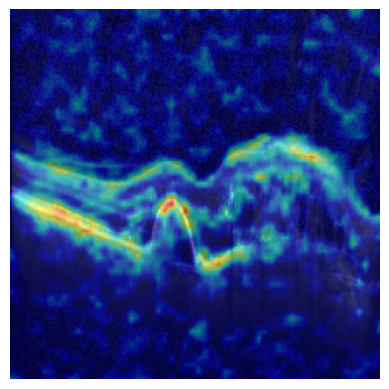

In [ ]:
# Denseblock 1 이후 transition1의 conv에 적용
grad_cam = GradCam(model=densenet121_test.densenet, module1='features',module2 ='transition1', layer='conv')
img = cv2.imread(test_img_path, 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
input = preprocess_image(img)
mask = grad_cam(input, None)
result = show_cam_on_image(img, mask)
plt.axis('off') # 창에있는 x축 y축 제거
plt.imshow(result)
plt.show()

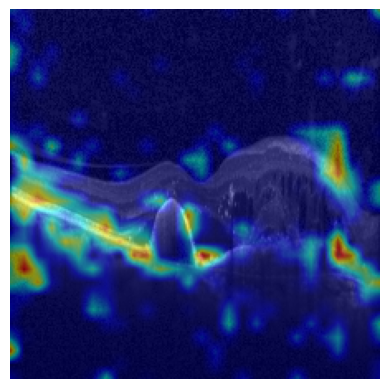

In [ ]:
# Denseblock 2 이후 transition2의 conv에 적용
grad_cam = GradCam(model=densenet121_test.densenet, module1='features',module2 ='transition2', layer='conv')
img = cv2.imread(test_img_path, 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
input = preprocess_image(img)
mask = grad_cam(input, None)
result = show_cam_on_image(img, mask)
plt.axis('off') # 창에있는 x축 y축 제거
plt.imshow(result)
plt.show()

c:\ProgramData\miniconda3\envs\for_learning\lib\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
c:\ProgramData\miniconda3\envs\for_learning\lib\site-packages\torch\nn\functional.py:4158: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


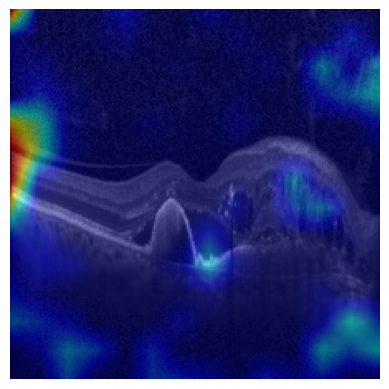

In [ ]:
# Denseblock 3 이후 transition3의 conv에 적용
grad_cam = GradCam(model=densenet121_test.densenet, module1='features',module2 ='transition3', layer='conv')
img = cv2.imread(test_img_path, 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
input = preprocess_image(img)
mask = grad_cam(input, None)
result = show_cam_on_image(img, mask)
plt.axis('off') # 창에있는 x축 y축 제거
plt.imshow(result)
plt.show()

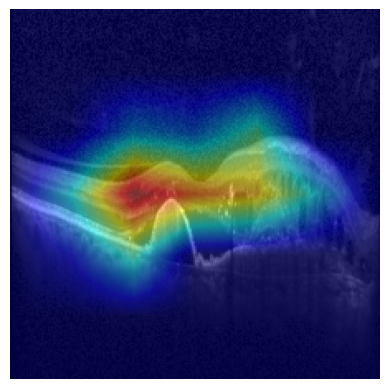

In [ ]:
# Denseblock 4 이후 transition4의 conv에 적용
grad_cam = GradCam(model=densenet121_test, module1='densenet',module2 ='features', layer='norm5')
img = cv2.imread(test_img_path, 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
input = preprocess_image(img)
mask = grad_cam(input, None)
result = show_cam_on_image(img, mask)
plt.axis('off') # 창에있는 x축 y축 제거
plt.imshow(result)
plt.show()

../data/OCT\test\CNV\CNV-1980926-1.jpeg


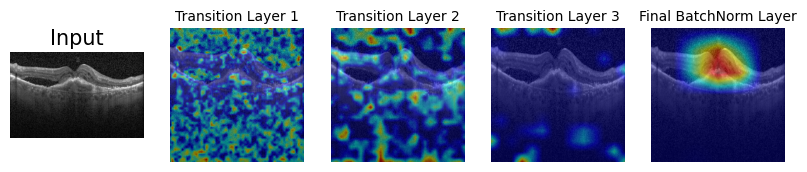

In [ ]:
# Layer 1,2,3,4 각각의 마지막 conv layer에 대한 grad cam
data_dir = '../data/OCT'
test_dir_name = 'test'
test_img_list = sorted(glob.glob(os.path.join(data_dir, test_dir_name, '*','*')))
img_idx = np.random.randint(len(test_img_list))
test_img_path = test_img_list[img_idx]
print(test_img_path)

fig = plt.figure(figsize=(10,40))
fig.add_subplot(1, 5, 1)
plt.title('Input', fontsize=15)
plt.imshow(Image.open(test_img_path), cmap='gray')
plt.axis('off') # 창에있는 x축 y축 제거

for i in range(1,5):
    if i != 4:
        grad_cam = GradCam(model=densenet121_test.densenet, module1='features', module2 ='transition'+str(i), layer='conv')
    elif i == 4:
        grad_cam = GradCam(model=densenet121_test, module1='densenet',module2 ='features', layer='norm5')
    img = cv2.imread(test_img_path, 1)
    img = np.float32(cv2.resize(img, (224, 224))) / 255
    input = preprocess_image(img)
    mask = grad_cam(input, None)
    result = show_cam_on_image(img, mask)
    fig.add_subplot(1, 5, i+1)
    if i != 4:
        plt.title(f'Transition Layer {i}', fontsize=10)
    elif i == 4:
        plt.title('Final BatchNorm Layer', fontsize=10)
    plt.imshow(result)
    plt.axis('off') # 창에있는 x축 y축 제거
plt.show()